In [ ]:
# add project root (parent of figures) to module search path
import sys, os
sys.path.insert(0, os.path.abspath('/home/reilly/ai_scientist_project'))
# import packages
import numpy as np
import optax
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
# import local modules
import utils, loss_functions, seed_programs, hypothesis_engine


# Model Definitions 
## (Uncomment the model you want)

In [1278]:
# # BASELINE MODEL
# neuron_model = seed_programs.neuron_model_2_jax
# parameter_estimator = seed_programs.parameter_estimator_2

In [1286]:
# AI MODEL

def neuron_model_numpy(theta,
                    theta_pref_1=0.0,
                    baseline=0.0,
                    amplitude_1=1.0,
                    width_ccw_1=1.0,
                    width_cw_1=1.0,
                    exponent_1=2.0,
                    theta_pref_2=np.pi,
                    amplitude_2=0.0,
                    width_ccw_2=1.0,
                    width_cw_2=1.0,
                    exponent_2=2.0):
    """"
    parent_model_1: VariableExponent_AsymmetricBimodalModel
    parent_model_2: IndependentLocation_AsymmetricPrimaryModel

    Equation:
    Helper Functions:
    _signed_circ_diff_rad(angle, preferred_angle) = arctan2(sin(angle - preferred_angle), cos(angle - preferred_angle))

    Component 1:
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)
    effective_width_1 = width_ccw_1 if signed_diff_1 < 0 else width_cw_1
    component_1 = amplitude_1 * exp(-0.5 * (abs(signed_diff_1) / effective_width_1)**exponent_1)

    Component 2:
    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)
    effective_width_2 = width_ccw_2 if signed_diff_2 < 0 else width_cw_2
    component_2 = amplitude_2 * exp(-0.5 * (abs(signed_diff_2) / effective_width_2)**exponent_2)

    Response:
    response = baseline + component_1 + component_2

    This model creates a comprehensive bimodal tuning curve by intelligently combining and enhancing the most effective
    features from its parent models, targeting specific shortcomings observed in the provided neural data.

    Improvements:
    1.  **Unified Peak Shape Flexibility and Asymmetry**: This model brings together the concept of variable exponents
        (`exponent_1`, `exponent_2` from `parent_model_1`) and asymmetric tuning widths for both peaks (`width_ccw_1`, `width_cw_1`, `width_ccw_2`, `width_cw_2`,
        inheriting from `parent_model_1`'s `tuning_width_pos/neg` for both peaks and `parent_model_2`'s `width_left/right` for the primary).
        This provides unparalleled control over the ""peakedness"" (e.g., sharper than Gaussian for high exponents,
        or fatter tails for low exponents to better fit broader shoulders as seen in Cell 91, 169) and the side-to-side
        asymmetry of *both* the primary and secondary response profiles. `parent_model_2` lacked this crucial flexibility for both peaks.

    2.  **Fully Independent Secondary Peak Placement**: Crucially, this model retains `parent_model_2`'s enhancement of allowing the secondary
        preferred direction (`theta_pref_2`) to be fully independent. Unlike `parent_model_1`, which constrained the
        secondary peak to be an offset from the primary's antipodal angle, `theta_pref_2` can be optimized freely. This is vital
        for capturing neurons with complex bimodal tuning where the secondary peak is not strictly 180 degrees from the primary
        (as observed in cells like Cell 1 and Cell 222 in previous models' descriptions, implying non-antipodal secondary peaks).

    3.  **Enhanced Fit Accuracy:** By integrating these powerful and complementary features, this model is designed to
        overcome systematic weaknesses of its predecessors. It provides a more robust framework to capture
        the detailed nuances of neuronal responses, from highly skewed and sharp primary peaks to broad and
        asymmetrically shaped secondary responses that can appear at any angle, thereby leading to a
        significantly lower overall loss.
    """
    # Helper function for signed circular difference, essential for asymmetric tuning
    # Result is in range (-pi, pi]
    def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
        delta = angle_radians - preferred_angle_radians
        return np.arctan2(np.sin(delta), np.cos(delta))

    # --- Peak 1: Asymmetric, Variable Exponent Gaussian component ---
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)

    # Select width based on the sign of the circular difference (counter-clockwise vs. clockwise)
    width_1_effective = np.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
    
    # Ensure widths are positive to prevent numerical instability (e.g., division by zero or log of non-positive)
    width_1_effective = np.maximum(width_1_effective, 1e-6) 

    # Calculate the first peak's contribution with variable exponent
    # abs(signed_diff_1) is used because the exponent should operate on the magnitude of the difference.
    peak1_component = amplitude_1 * np.exp(-0.5 * (np.abs(signed_diff_1) / width_1_effective) ** exponent_1)

    # --- Peak 2: Asymmetric, Variable Exponent Gaussian component with independent preferred angle ---
    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)

    # Select width based on the sign of the circular difference for the second peak
    width_2_effective = np.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)

    # Ensure widths are positive
    width_2_effective = np.maximum(width_2_effective, 1e-6)

    # Calculate the second peak's contribution with variable exponent
    peak2_component = amplitude_2 * np.exp(-0.5 * (np.abs(signed_diff_2) / width_2_effective) ** exponent_2)

    # Total model response
    return baseline + peak1_component + peak2_component

def neuron_model(theta,
                theta_pref_1=0.0,
                baseline=0.0,
                amplitude_1=1.0,
                width_ccw_1=1.0,
                width_cw_1=1.0,
                exponent_1=2.0,
                theta_pref_2=jnp.pi,
                amplitude_2=0.0,
                width_ccw_2=1.0,
                width_cw_2=1.0,
                exponent_2=2.0):
    
    width_ccw_1, width_cw_1 = jnp.clip(width_ccw_1, 1e-6, None), jnp.clip(width_cw_1, 1e-6, None)
    width_ccw_2, width_cw_2 = jnp.clip(width_ccw_2, 1e-6, None), jnp.clip(width_cw_2, 1e-6, None)
    exponent_1, exponent_2 = jnp.clip(exponent_1, 0.1, 5.0), jnp.clip(exponent_2, 0.1, 5.0)
    
    def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
        delta = angle_radians - preferred_angle_radians
        return jnp.arctan2(jnp.sin(delta), jnp.cos(delta))

    eps = 1e-12
    signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1) + eps  # Add small epsilon to avoid log(0) issues
    width_1_effective = jnp.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
    width_1_effective = jnp.maximum(width_1_effective, 1e-6)
    peak1_component = amplitude_1 * jnp.exp(-0.5 * (jnp.abs(signed_diff_1) / width_1_effective) ** exponent_1)

    signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2) + eps  # Add small epsilon to avoid log(0) issues
    width_2_effective = jnp.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)
    width_2_effective = jnp.maximum(width_2_effective, 1e-6)
    peak2_component = amplitude_2 * jnp.exp(-0.5 * (jnp.abs(signed_diff_2) / width_2_effective) ** exponent_2)

    return baseline + peak1_component + peak2_component

def parameter_estimator(stimuli, spike_counts):
    """
    Estimates parameters for the neuron_model_v3 based on stimulus angles and observed spike counts.
    This estimator employs statistical principles to identify and characterize tuning curve peaks,
    including baseline, amplitude, asymmetric widths, preferred directions, and exponents for
    two potential peaks.

    Parameters are estimated directly from a smoothed firing rate curve, aiming for a simple
    yet robust initial estimation suitable for generalized Gaussian-like tuning profiles.

    Parameters:
    stimuli (np.ndarray): An array of stimulus angles in radians (0 to 2*pi).
    spike_counts (np.ndarray): An array of spike counts corresponding to each stimulus.

    Returns:
    np.ndarray: An array containing the estimated parameters in the following order:
                [theta_pref_1, baseline, amplitude_1, width_ccw_1, width_cw_1,
                 exponent_1, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, exponent_2]
    """
    # --- Configuration Constants ---
    n_bins = 180  # Number of angular bins for tuning curve estimation
    kernel_sigma = 2.5 # Sigma for Gaussian smoothing kernel
    min_peak_amplitude = 0.5 # Min amplitude (spikes/stimulus) above baseline for a peak to be considered valid
    min_model_width = 1e-6 # Minimum allowed width for numerical stability (as per model)
    default_width_value = 1.0 # Default width for non-significant peaks or non-determinable widths
    min_exponent = 0.1 # Minimum allowed exponent value
    max_exponent = 5.0 # Maximum allowed exponent value
    default_exponent_value = 2.0 # Default exponent (Gaussian)
    min_second_peak_ratio = 0.1 # Min amplitude of secondary peak relative to primary
    min_second_peak_separation = np.pi / 4 # Min angular separation between primary and secondary peaks

    # --- 1. Binning and Smoothing ---
    # Convert stimuli to bin indices, handle wrap-around implicitly by modulo in bincount
    bin_idx = ((stimuli * n_bins) / (2 * np.pi)).astype(np.int32)
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)

    sums = np.bincount(bin_idx, weights=spike_counts, minlength=n_bins)
    counts = np.bincount(bin_idx, minlength=n_bins)

    # Create Gaussian smoothing kernel
    kernel_radius = int(3 * kernel_sigma)
    x_kernel = np.arange(-kernel_radius, kernel_radius + 1)
    kernel = np.exp(-0.5 * (x_kernel / kernel_sigma) ** 2)
    kernel /= (np.sum(kernel) + 1e-8) # Normalize kernel

    # Pad arrays for circular convolution
    pad = len(kernel) // 2
    sums_padded = np.pad(sums, (pad, pad), mode='wrap')
    counts_padded = np.pad(counts, (pad, pad), mode='wrap')

    # Convolve to get smoothed sum of spikes and counts
    num_conv = np.convolve(sums_padded, kernel, mode='valid')
    den_conv = np.convolve(counts_padded, kernel, mode='valid')

    # Calculate smoothed tuning curve (avoid division by zero)
    tuning_curve = np.zeros_like(num_conv, dtype=float)
    valid_den_mask = den_conv > 1e-8
    tuning_curve[valid_den_mask] = num_conv[valid_den_mask] / den_conv[valid_den_mask]

    angle_step = 2 * np.pi / n_bins

    # --- 2. Baseline Estimation ---
    # Baseline cannot be negative
    baseline_est = np.maximum(0.0, np.min(tuning_curve))

    # --- Helper function for estimating peak shape parameters ---
    def _get_peak_params_simple(peak_idx_val, peak_idx, bsl, tc, n_bns, ang_step,
                                min_w, def_w, min_exp, max_exp, def_exp, min_amp_thresh):
        amp = peak_idx_val - bsl
        if amp < min_amp_thresh:
            return amp, def_w, def_w, def_exp # Return default parameters if amplitude too small

        # Find bins where tuning curve drops below half-max
        target_half_val = bsl + amp / 2.0
        half_ccw_bins, half_cw_bins = 0, 0
        for k in range(1, n_bns // 2 + 1):
            if half_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_half_val:
                half_ccw_bins = k
            if half_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_half_val:
                half_cw_bins = k
            if half_ccw_bins > 0 and half_cw_bins > 0:
                break
        
        # Calculate width (v1-style, implicitly assuming Gaussian form for width parameter base)
        SQRT_2_LOG_2 = np.sqrt(2 * np.log(2)) 
        width_ccw = (half_ccw_bins * ang_step) / SQRT_2_LOG_2 if half_ccw_bins > 0 else def_w
        width_cw = (half_cw_bins * ang_step) / SQRT_2_LOG_2 if half_cw_bins > 0 else def_w
        
        # Clip widths to valid range
        width_ccw = np.clip(width_ccw, min_w, np.pi)
        width_cw = np.clip(width_cw, min_w, np.pi)

        # Find bins where tuning curve drops below quarter-max for exponent estimation
        target_qtr_val = bsl + amp / 4.0
        qtr_ccw_bins, qtr_cw_bins = 0, 0
        for k in range(1, n_bns // 2 + 1):
            if qtr_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_qtr_val:
                qtr_ccw_bins = k
            if qtr_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_qtr_val:
                qtr_cw_bins = k
            if qtr_ccw_bins > 0 and qtr_cw_bins > 0:
                break
        
        # Exponent estimation (log(2) / log(dist_qtr / dist_half))
        exponent_estimates = []
        if half_ccw_bins > 0 and qtr_ccw_bins > half_ccw_bins: # Ensure ratio > 1 for valid log
            exponent_estimates.append(np.log(2) / np.log(qtr_ccw_bins / half_ccw_bins))
        if half_cw_bins > 0 and qtr_cw_bins > half_cw_bins:
            exponent_estimates.append(np.log(2) / np.log(qtr_cw_bins / half_cw_bins))
        
        # Take mean of valid estimates, else default
        exponent = np.mean(exponent_estimates) if exponent_estimates else def_exp
        exponent = np.clip(exponent, min_exp, max_exp)
        
        return amp, width_ccw, width_cw, exponent

    # --- 3. Peak Identification and Parameter Estimation ---
    # Find all local maxima in the smoothed tuning curve
    local_maxima = []
    for i in range(n_bins):
        prev_val = tuning_curve[(i - 1 + n_bins) % n_bins]
        next_val = tuning_curve[(i + 1) % n_bins]
        if tuning_curve[i] >= prev_val and tuning_curve[i] >= next_val:
            local_maxima.append((tuning_curve[i], i))
    local_maxima.sort(key=lambda x: x[0], reverse=True) # Sort by peak amplitude (descending)

    # Initialize all output parameters with model defaults (if no peak is found)
    theta_pref_1 = 0.0
    amplitude_1 = default_width_value # amplitude for primary peak default to 1 for non-zero contribution if peak is small
    width_ccw_1, width_cw_1, exponent_1 = default_width_value, default_width_value, default_exponent_value
    
    theta_pref_2 = np.pi # Antipodal to default theta_pref_1
    amplitude_2 = 0.0 # Default no second peak
    width_ccw_2, width_cw_2, exponent_2 = default_width_value, default_width_value, default_exponent_value

    # Process Primary Peak
    if local_maxima:
        peak_1_val, peak_1_idx = local_maxima[0]
        # Estimate parameters for the primary (highest) peak
        amplitude_1, width_ccw_1, width_cw_1, exponent_1 = \
            _get_peak_params_simple(peak_1_val, peak_1_idx, baseline_est, tuning_curve, n_bins, angle_step,
                                    min_model_width, default_width_value, min_exponent, max_exponent,
                                    default_exponent_value, min_peak_amplitude)
        theta_pref_1 = peak_1_idx * angle_step
        
        # Process Secondary Peak (if a suitable candidate exists)
        if len(local_maxima) > 1:
            # Iterate through other local maxima to find a suitable secondary peak
            for i in range(1, len(local_maxima)):
                peak_2_val_candidate, peak_2_idx_candidate = local_maxima[i]
                current_amplitude_2_candidate = peak_2_val_candidate - baseline_est
                current_theta_pref_2_candidate = peak_2_idx_candidate * angle_step
                
                # Check amplitude significance relative to primary peak's estimated amplitude
                if current_amplitude_2_candidate < (amplitude_1 * min_second_peak_ratio):
                    continue # Skip if too small compared to the primary peak
                
                # Check angular separation from the *primary* peak
                # np.arctan2(sin(a-b), cos(a-b)) gives circular distance in [-pi, pi]
                peak_sep_rad = np.abs(np.arctan2(np.sin(theta_pref_1 - current_theta_pref_2_candidate),
                                                 np.cos(theta_pref_1 - current_theta_pref_2_candidate)))
                if peak_sep_rad < min_second_peak_separation:
                    continue # Skip if too close to the primary peak

                # Valid secondary peak found, estimate its parameters
                amplitude_2, width_ccw_2, width_cw_2, exponent_2 = \
                    _get_peak_params_simple(peak_2_val_candidate, peak_2_idx_candidate, baseline_est, tuning_curve, n_bins, angle_step,
                                            min_model_width, default_width_value, min_exponent, max_exponent,
                                            default_exponent_value, min_peak_amplitude)
                theta_pref_2 = current_theta_pref_2_candidate
                
                # Break after finding the first suitable secondary peak (highest amplitude among remaining candidates)
                break
    
    # --- Pack and return parameters in the correct order for neuron_model_v3 ---
    return np.array([theta_pref_1, baseline_est, amplitude_1, width_ccw_1, width_cw_1,
                     0.5, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, 0.5])

param_names = ['theta_pref_1', 'baseline', 'amplitude_1', 'width_ccw_1', 'width_cw_1',
               'exponent_1', 'theta_pref_2', 'amplitude_2', 'width_ccw_2', 'width_cw_2',
               'exponent_2']

# Data Preprocessing

In [ ]:
# To train the model, we only extract the reliably measured responses (ie, > 0).
# If you wish, you may define a training and testing set of trials as we do in the genetic algorithm.
# To increase the number of data points, I simply optimize the parameters on all trials here, as we 
# already know that this model has a high cross-validated performance.

conc_thresh, activity_thresh = 0.5, 0.4 # thresholds for conc and activity
# conc_thresh, activity_thresh = 0.35, 0.45 # thresholds for conc and activity
data_dir = '/home/reilly/Downloads/8279387/gratings_drifting_GT1_2019_04_12_1.npy'
# data_dir = '/Users/reillytilbury/Desktop/gratings/gratings_static_GT1_2019_04_17_1.npy'
neural_data = np.load(data_dir, allow_pickle=True)
neural_data = neural_data.item()
response = utils.extract_stimulus_related_response(neural_data, n_pcs=0)
response_full = response.copy()  # keep the full response for later use
angles = neural_data['istim']
angles_full = angles.copy()  # keep the full angles for later use
n_trials = response.shape[1]
n_trials_small = int(n_trials * activity_thresh)

# filter 
active = (response > 0).astype(np.float32)
firing_probs = np.mean(active, axis=1)
conc = np.abs(np.sum(np.exp(2j * angles)[np.newaxis, :] * response, axis=1) / np.sum(response, axis=1))
good_cells = np.where((firing_probs > activity_thresh) & (conc > conc_thresh))[0]
n_good_cells = len(good_cells)
conc = conc[good_cells]
firing_probs = firing_probs[good_cells]
response_full = response_full[good_cells, :]
print(f"Selected {len(good_cells)} cells with activity > {activity_thresh} and concentration > {conc_thresh}.")

# update angles and response to be (n_cells_small, n_trials_small) and (n_cells_small, n_trials_small)
response_cropped, angles_cropped = np.zeros((len(good_cells), n_trials_small)), np.zeros((len(good_cells), n_trials_small))
for i, cell in enumerate(good_cells):
    active_trials = response[cell] > 0
    active_trials_idx = np.where(active_trials)[0][:n_trials_small]
    response_cropped[i] = response[cell, active_trials_idx]
    angles_cropped[i] = angles[active_trials_idx]
    
# update response and angles to be the cropped versions and convert to JAX arrays
response, angles = jnp.asarray(response_cropped), jnp.asarray(angles_cropped)
# normalize response of each cell
response_norms = jnp.linalg.norm(response, axis=1)
response = 100 * response / response_norms[:, None]  # scale to 100
# scale full response by the same norms
response_full = 100 * response_full / response_norms[:, None]  # scale to 100
# delete neural_data to free memory 
del neural_data

Selected 2679 cells with activity > 0.4 and concentration > 0.5.


# Parameter Fitting

In [ ]:
# Fit parameters using the param estimator for a starting point and then using ADAM to optimize them.
# On a GPU, this takes about 5 seconds per 1000 steps.

params_init = hypothesis_engine.compute_initial_params(
    param_estimator=parameter_estimator,
    neuron_model=neuron_model,
    x=np.asarray(angles),
    y=np.asarray(response)
)

# 1. build the loss function -----------------------------------
n_cells, n_params = params_init.shape
loss_single_cell = lambda params, x_data, y_data: jnp.mean(loss_functions.quadratic_loss(neuron_model(x_data, *params), y_data), axis=-1)
# vectorize the loss function for all cells. The inputs will have shapes:
# - params: (n_cells, n_params)
# - x_data: (n_cells, n_trials)
# - y_data: (n_cells, n_trials)
loss_total = jax.vmap(loss_single_cell, in_axes=(0, 0, 0), out_axes=0)
loss_param = lambda params_flat: jnp.mean(loss_total(params_flat.reshape(n_cells, n_params), angles, response))
loss_param = jax.jit(loss_param)  # JIT compile the loss function for performance
loss_param_and_grad = jax.value_and_grad(loss_param)

# ------------------------------------------------------------------
# 2.  build the Adam optimiser -------------------------------------
learning_rate = 3e-3       # good default; tune if needed
beta1, beta2  = 0.9, 0.999    # the usual Adam constants

opt = optax.adam(learning_rate, b1=beta1, b2=beta2, eps=1e-8)
opt_state = opt.init(params_init.reshape(-1))  # Flatten params for the optimizer

@jax.jit
def train_step(params, opt_state):
    loss, grad = loss_param_and_grad(params)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# ------------------------------------------------------------------
# 3.  iterate -------------------------------------------------------
num_steps =  3_000            # or stop on validation patience
print_every = 100

params = params_init.reshape(-1)  # Flatten params for the optimizer
best_params = params.copy()  # Keep track of the best parameters
best_loss = float('inf')  # Initialize best loss to infinity
for step in range(1, num_steps + 1):
    params, opt_state, loss_val = train_step(params, opt_state)
    if step % print_every == 0:
        print(f"step {step:4d}  loss {loss_val:.4f}")
    if loss_val < best_loss:
        best_loss = loss_val
        best_params = params.copy()

params = best_params.reshape(n_cells, n_params)  # Reshape back to (n_cells, n_params)

step  100  loss 30.8060
step  200  loss 29.9637
step  300  loss 29.4171
step  400  loss 29.0901
step  500  loss 28.9034
step  600  loss 28.7952
step  700  loss 28.7288
step  800  loss 28.6873
step  900  loss 28.6590
step 1000  loss 28.6353
step 1100  loss 28.6179
step 1200  loss 28.6012
step 1300  loss 28.5870
step 1400  loss 28.5798
step 1500  loss 28.5706
step 1600  loss 28.5664
step 1700  loss 28.5589
step 1800  loss 28.5545
step 1900  loss 28.5483
step 2000  loss 28.5413


# LOWESS Mean Calculations

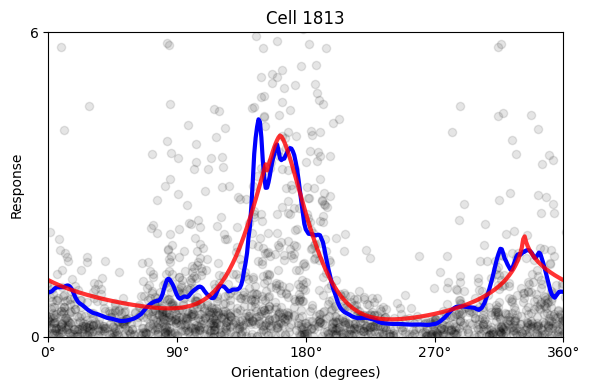

In [1335]:
# compute lowess mean for a single cell and plot results against neuron model

import statsmodels.api as sm

cell_index = np.random.randint(0, n_cells)  # Randomly select a cell to plot

# These are some cells that have interesting responses. 
# They come from preprocessing with activity_thresh = 0.5 and conc_thresh = 0.5
# cell_index = 124 # non pi separation
# cell_index = 390 # non pi sep
# cell_index = 495
# cell_index = 124 # nice non pi separation
# cell_index = 63 # 2 asymetric peaks
# cell_index = 215 # very spiky
# cell_index = 136 # spiky
# cell_index = 151 # spiky
# cell_index = 179 # spiky
# cell_index = 202 # very spiky and non pi separation
# cell_index = 239 # very spiky 
# cell_index = 240 # has nice non pi separation
# cell_index = 445 # very asymmetric
# cell_index = 594 # nice non pi separation
# cell_index = 643 # very asymmetric

# LOWESS mean estimation.
# we add angles and responses shifted by -2pi and +2pi to the data to make the plot more readable.
# this is a trick so that angles near 2pi are seen as close to angles near 0.
offset = 0  # angle shift to make the plot more readable. Default is 0.
evaluation_points = np.linspace(0, 2 * np.pi, 360, endpoint=False)
lowess = sm.nonparametric.lowess
x = angles[cell_index].copy()
y = response[cell_index].copy()
n_responses = len(x)
# if we want to shift the angles to be centred around any particular values, handle that here
x = (x - offset) % (2 * np.pi)
x = np.concatenate([x - 2 * np.pi, x, x + 2 * np.pi])
y = np.concatenate([y, y, y])
mean_est = lowess(y, x, frac=0.06 / 3, it=0, delta=0.0, return_sorted=True)
angle_sorted = mean_est[:,0]
resp_smoothed = mean_est[:,1]
mean_est_interp = np.interp(evaluation_points, angle_sorted, resp_smoothed)

# plot binned means and neuron model with actual responses
plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=35, alpha=0.1, color="#000000")
plt.plot(evaluation_points, mean_est_interp, lw=3, color="blue", label="Local Mean")
plt.plot(evaluation_points, neuron_model(evaluation_points + offset, *params[cell_index]), lw=3, color="red",
         label="AI Model", alpha=0.8)
# plt.legend(loc="upper right", fontsize=8)
plt.xlabel("Orientation (degrees)",)
plt.ylabel("Response")
plt.ylim(np.min(mean_est_interp), 1.4 * np.max(mean_est_interp))
plt.xlim(0, 2 * np.pi)
plt.title(f"Cell {cell_index}")
plt.yticks([0, 1.4 * np.max(mean_est_interp)], ["0", f"{int(2 * np.max(mean_est_interp))}"])
plt.xticks(np.linspace(0, 2 * np.pi, 5), labels=[f"{int(np.degrees(x))}°" for x in np.linspace(0, 2 * np.pi, 5)])
# add legend off the plot, to the right
# plt.legend(loc="upper left", fontsize=16, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
# compute lowess mean for all cells

from tqdm import tqdm
n_angle_bins = 360
evaluation_points = np.linspace(0, 2 * np.pi, n_angle_bins, endpoint=False)
lowess_means = np.zeros((response.shape[0], n_angle_bins))

# loop over cells
for i in tqdm(range(response.shape[0])):
    x = angles[i].copy()
    y = response[i].copy()
    n_responses = len(x)
    x = np.concatenate([x - 2 * np.pi, x, x + 2 * np.pi])
    y = np.concatenate([y, y, y])
    mean_est = lowess(y, x, frac=0.06 / 3, it=0, delta=0.0, return_sorted=True)
    angle_sorted = mean_est[:,0]
    resp_smoothed = mean_est[:,1]
    lowess_means[i] = np.interp(evaluation_points, angle_sorted, resp_smoothed)

100%|██████████| 2679/2679 [03:36<00:00, 12.38it/s]


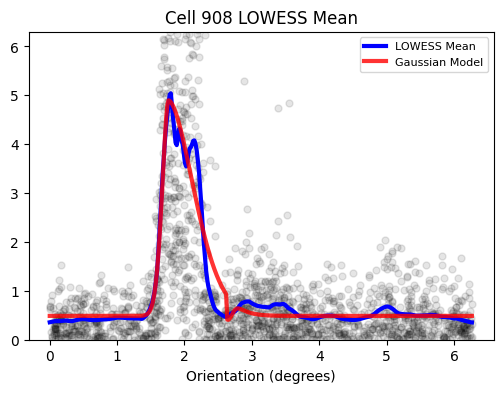

In [ ]:
# test lowess results for a single cell and plot results against neuron model

cell_index = np.random.randint(0, response.shape[0])  # random cell index for plotting
plt.figure(figsize=(6, 4))
plt.scatter(angles[cell_index], response[cell_index], s=25, alpha=0.1, color="#000000")
plt.plot(evaluation_points, lowess_means[cell_index], lw=3, color="blue", label="LOWESS Mean")
plt.plot(evaluation_points, neuron_model(evaluation_points, *params[cell_index]), lw=3, color="red",
         label="Gaussian Model", alpha=0.8)
plt.xlabel("Orientation (degrees)")
plt.ylim(0, 1.25 * np.max(lowess_means[cell_index]))
plt.title(f"Cell {cell_index} LOWESS Mean")
plt.legend(loc="upper right", fontsize=8)
plt.show()

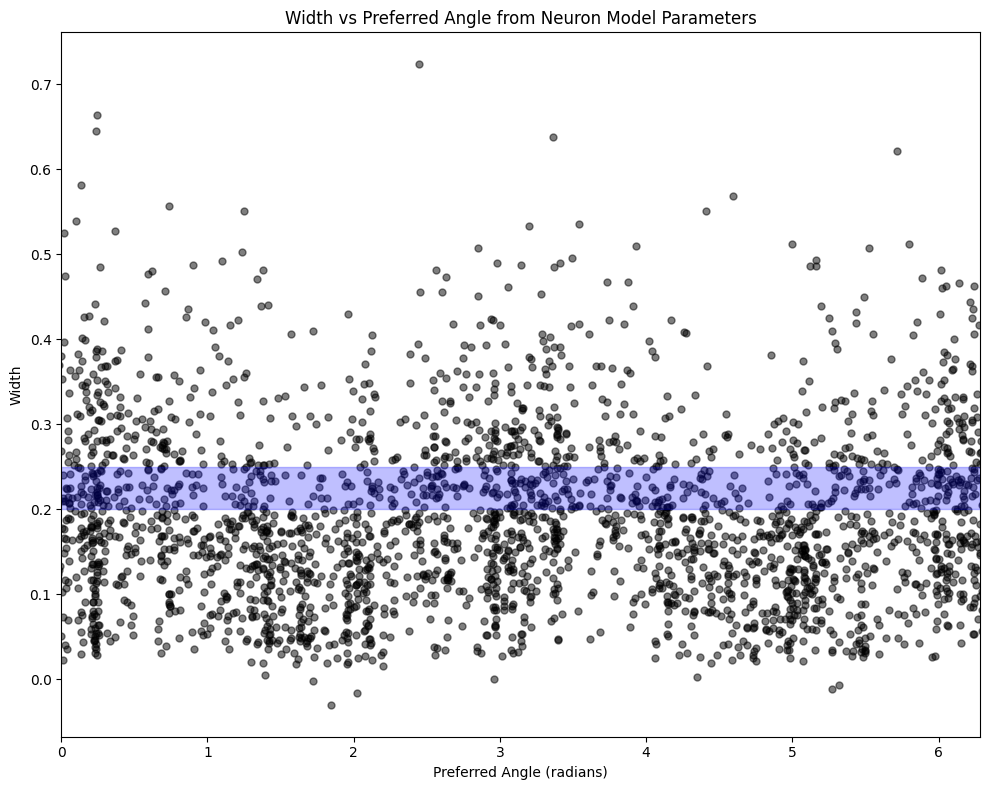

In [ ]:
# plot width vs preferred angle for all cells
theta_pref = params[:, 0]
width = (params[:, 3] + params[:, 4]) / 2  # average of ccw and cw widths
plt.figure(figsize=(10, 8))
plt.scatter(theta_pref, width, s=25, alpha=0.5, color="#000000")
plt.xlabel("Preferred Angle (radians)")
plt.ylabel("Width")
plt.title("Width vs Preferred Angle from Neuron Model Parameters")
plt.fill_betweenx(np.linspace(0.2, 0.25, 100), 0, 2 * np.pi, color="blue", alpha=0.25)
plt.xlim(0, 2 * np.pi)
plt.tight_layout()
plt.show()

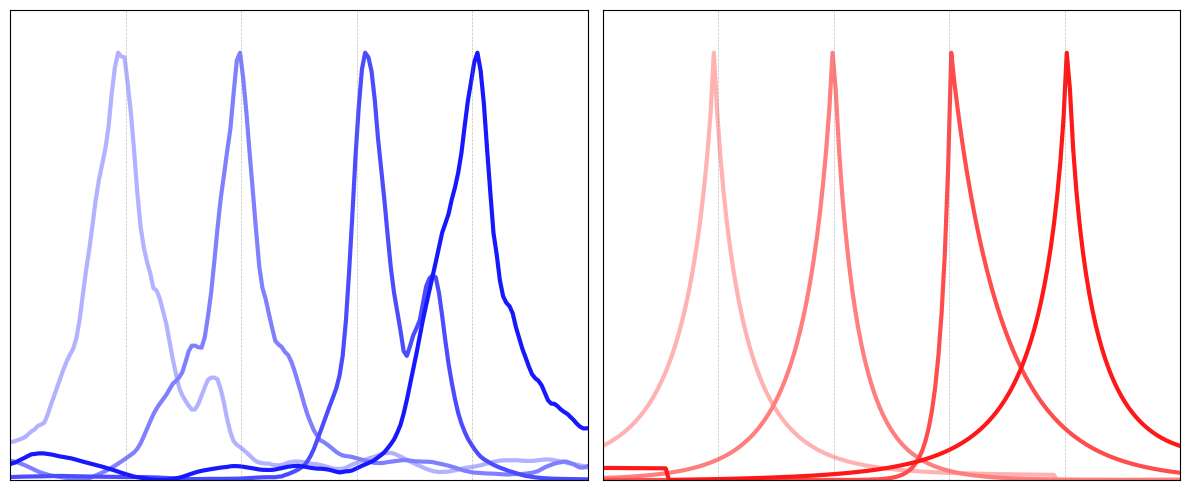

In [ ]:
# Plot an ensemble of cells
# We do this by selecting cells near a set of desired angles, and plotting their LOWESS means and neuron model predictions.
# We only look at a range of 180 degrees so that the plots are more readable.
# we randomize the minimum angle and also randomly select cells near the desired angles.
# This allows us to plot a diverse set of cells with interesting responses.

theta_min = np.random.uniform(0, np.pi)
n_cells_plot = 4
theta_pref = params[:, 0]
width = (params[:, 3] + params[:, 4]) / 2  # average of ccw and cw widths
cell_plot_indices = np.zeros(n_cells_plot, dtype=int)
desired_width_range = (0.05, 0.1)  # desired width range for selection
snr_threshold = np.percentile(lowess_means.max(axis=1), 50)
lowess_norm = (lowess_means - lowess_means.min(axis=1, keepdims=True)) / (lowess_means.max(axis=1, keepdims=True) - lowess_means.min(axis=1, keepdims=True))
# define roughness as number of turning points in the LOWESS mean in the desired range
mask = (evaluation_points >= theta_min) & (evaluation_points <= theta_min + np.pi)
roughness = np.sum(np.abs(np.diff(np.sign(np.diff(lowess_norm[:, mask], axis=1)), axis=1)), axis=1)
selected_cells = np.where((width >= desired_width_range[0]) & 
                          (width <= desired_width_range[1]) &
                          (lowess_means.max(axis=1) >= snr_threshold))[0]
# take some of the selected cells with the lowest roughness
selected_cells = selected_cells[np.argsort(roughness[selected_cells])[:len(selected_cells) // 2]]

# define neighbourhood around each desired angle
noise_level = 0.025
for i in range(n_cells_plot):
    desired_peak_angle = (theta_min + (i + 1) * np.pi / (n_cells_plot + 1)) % (2 * np.pi) + np.random.uniform(-noise_level, noise_level)
    # find the cell with the closest preferred angle to the desired peak angle
    dists = np.abs(theta_pref[selected_cells] - desired_peak_angle)
    cell_plot_indices[i] = selected_cells[np.argmin(dists)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
cmap = plt.get_cmap('bwr')
for i, cell_index in enumerate(cell_plot_indices):
    # plot the LOWESS mean for the cell on the left and the neuron model on the right
    lowess_mean = lowess_means[cell_index].copy()
    lowess_mean = (lowess_mean - lowess_mean.min()) / (lowess_mean.max() - lowess_mean.min())
    prediction = neuron_model(evaluation_points, *params[cell_index])
    prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())
    t = 0.15 + 0.3 * (i / (n_cells_plot - 1))
    ax[0].plot(evaluation_points, lowess_mean, lw=3, label=f"Cell {cell_index} LOWESS Mean", color=cmap(0.5 - t))
    ax[1].plot(evaluation_points, prediction, lw=3, label=f"Cell {cell_index} Neuron Model", color=cmap(t + 0.5))

# format axes
for i, a in enumerate(ax):
    # if i == 0:
    #     a.set_ylabel("Response (normalized)")
    # a.set_xlabel("Orientation (degrees)")
    a.set_xlim(theta_min, theta_min + np.pi)
    a.set_ylim(0, 1.1)
    # plot vertical lines at target angles
    for j in range(n_cells_plot):
        target_angle = theta_min + (j + 1) * np.pi / (n_cells_plot + 1)
        a.axvline(target_angle, color='gray', linestyle='--', lw=0.5, alpha=0.5)
    a.set_yticks([])
    a.set_xticks([])
plt.tight_layout()
plt.show()